# 金融テキストマイニングと　ChatGPTによるセンチメント

本日の内容：

- 従来のテキストマイニング手法のおさらい
    - 形態素解析からの共起解析
- ChatGPTを使いこなすために
    - パラメータを追加すると回答がシャープになる
    - 分類モデルによるセンチメント生成

「Pythonによる金融テキストマイニング」より

１章:テキストマイニングの分析手法
   - 記号処理とパターン処理に分けられる
   - 形態素解析ー構文解析ー意味解析
   - ディープラーニングの手法

２章：環境構築 コンテナ利用
  そのままでは動かなかった。M1 Mac問題

３章：テキストマイニングツールの使い方
 ここは動かしてみる

 頻出単語と文書頻出単語の計測、可視化

 テキストの類似度を測る

４章：多変量解析による日銀レポート解析と債権市場予測

　過去のレポートを解析して時系列データ（債権価格）を組み合わせて

　CPR法を用いて債権市場の予測を行う。予測を用いたバックテストの結果は良かった。

　テキストマイニングでも特徴量を抽出できる、データソースと分析結果が明確に説明できるのが良い

　CPR法は、共起解析、主成分解析、回帰分析を組み合わせたもの

5章：ディープラーニングの価格予測
　割愛

6章：業績要因文の抽出

　有価証券報告書から業績要因文を抽出できる

　アナリストレポートは記載内容が異なるので難しい

7章：決算短信からの因果関係抽出

　BERTを使っての解析になるGPU必要

８章：テキストマイニング応用の課題と将来

  予測できるものもある

　透明性、頑強性、異常値検出可能、予測可能かの視点

　過学習になりがち、予測結果の説明ができるか、経済的因果の分析で課題がある


# 環境構築
## 利用するライブラリ
- MeCab


※brewをインストールしていることが前提(その方が楽)

### MeCabと単語の辞書をインストールしている
MeCab M1 Mac インストール
https://notemite.com/python/python-cabocha/#install
https://note.com/tukkidney/n/n4d295724e197


# 参考資料
https://www.asakura.co.jp/detail.php?book_code=27588
https://blog.hoxo-m.com/entry/2020/10/07/090258


## MeCabの動作確認
動作確認する文字列

In [1]:
text = "ビットコイン取引所でビットコインを買った"

### 形態素解析  辞書なし

In [2]:
import MeCab

def extract_words(text):
    words = []
    tagger = MeCab.Tagger(" ")
    for word_line in tagger.parse(text).split("\n") :
        if word_line.strip() == "EOS":
            break
        (word , temp) = word_line.split("\t")
        words.append(word)
    return words


In [3]:
words = extract_words(text)
print(words)

['ビット', 'コイン', '取引', '所', 'で', 'ビット', 'コイン', 'を', '買っ', 'た']


### 形態素解析  辞書あり

In [5]:
import MeCab

def extract_words(text):
    words = []
    tagger = MeCab.Tagger("-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd")
    for word_line in tagger.parse(text).split("\n") :
        if word_line.strip() == "EOS":
            break
        (word , temp) = word_line.split("\t")
        words.append(word)
    return words
 

In [6]:

words = extract_words(text)
print(words)


['ビットコイン', '取引所', 'で', 'ビットコイン', 'を', '買っ', 'た']


## TFIDFを計算する

TFIDFとは、文章中に多く頻出し　かつ　他の文章に出現しない言葉に高い評価をするスコアリング手法

TFは term frequency で語の頻度

IDF inversed documet frequencyで文章の頻度の逆数う

有価証券情報で動作を確認する。

####    データソース
https://github.com/chakki-works/CoARiJ

##### 言葉の頻度を可視化する関数 wordcloud

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

font_path_gothic = '/Library/Fonts/Arial Unicode.ttf'

import datetime

t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)

def output_wordcloud(words,filename=now.strftime('%Y%m%d%H%M%S') + ".png"):

    if len(words) == 0:
        return
    
    wordcloud = WordCloud(width=1920, height=1080, max_words=200,background_color="white", font_path=font_path_gothic).generate(words)
    wordcloud.to_file(filename)

    plt.imshow(wordcloud)

In [8]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


##### 形態素解析を行い名詞だけを抽出する

In [9]:

def extract_words(text):
    words = []
    tagger = MeCab.Tagger("-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd")
    for word_line in tagger.parse(text).split("\n") :
        if word_line.strip() == "EOS":
            break
        (word , temp) = word_line.split("\t")
        if temp.startswith("名詞"):
            words.append(word)
    return words


#### 有価証券報告書の名詞を形態素解析で抽出し、頻度が多い語を表示する

['/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_information_dividend_policy.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_finance_segment_information.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_business_risks.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_finance_voluntary_accounting_policy_change.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_information_shareholders.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_company_employees.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_company_affiliated_entities.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_business_risks.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_company_affiliated_entities.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A

100%|██████████| 34/34 [00:03<00:00, 10.13it/s]


当社 241
円 209
等 194
万 186
百 185
事業 168
取締役 134
１ 132
こと 107
セグメント 101


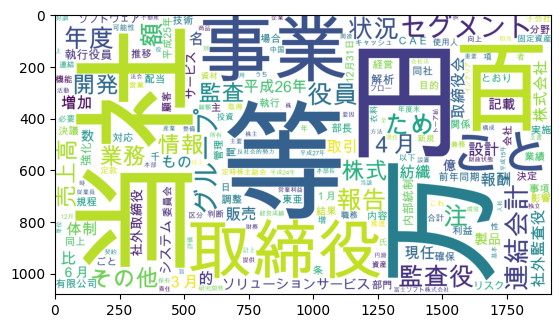

In [10]:
import glob
import collections
from tqdm import tqdm

# ファイルを読み込む
files = glob.glob("/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A*.txt", recursive=True)
print(files)

# 語の数を数えるためのハッシュ
word_hash = collections.defaultdict(int)

# ファイルを読み込んで、単語の数を数える
for f in tqdm(files):
    lines = [lines.strip() for lines in open(f, "r", encoding="utf-8")]
    for line in lines:
        if lines == "":
            continue
        words = extract_words(line)
        for w in words:
            word_hash[w] += 1

# 頻度の高い言葉をソートする
keys = sorted(word_hash.keys(), key=lambda k:word_hash[k], reverse=True)

for i, w in enumerate(keys[:10]):
    print(w,word_hash[w])

word_data=",".join(keys[:300])
output_wordcloud(word_data)

#### 有価証券報告書からTFIDFを計算する

['/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_information_dividend_policy.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_finance_segment_information.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_business_risks.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_finance_voluntary_accounting_policy_change.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_information_shareholders.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_company_employees.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_company_affiliated_entities.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_business_risks.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_company_affiliated_entities.txt', '/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A

  0%|          | 0/34 [00:00<?, ?it/s]

 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_information_dividend_policy.txt
配当 64.83671966625712
銭 20.349851365001356
日 12.524777047502038
60 12.262388523751017
当たり 12.262388523751017
株主 11.062138985451908
剰余金 11.062138985451908
中間 10.50750102158755
基盤 10.174925682500678
拡充 10.174925682500678
配当性向 10.174925682500678
株 10.010001362116734
こと 9.70916186176473
政策 9.262388523751019
期末 9.262388523751019
今後 9.262388523751019
金 9.262388523751019
決定 9.120431676770941
％ 8.827673731814885
決議 8.29660423908893
平成27年 8.29660423908893
発展 8.174925682500678
内部留保 8.174925682500678
利益配分 8.174925682500678
皆様 8.174925682500678
うえ 8.174925682500678
取締役会 7.507501021587551
実施 7.507501021587551
的 7.062138985451908
収益 7.005000681058367
配当,銭,日,60,当たり,株主,剰余金,中間,基盤,拡充,配当性向,株,こと,政策,期末,今後,金,決定,％,決議,平成27年,発展,内部留保,利益配分,皆様,うえ,取締役会,実施,的,収益,
 --- end   output --- 
 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_finance_segment

 35%|███▌      | 12/34 [00:00<00:00, 26.55it/s]

 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_company_affiliated_entities.txt
00 86.44895955500951
兼務 63.045006129525305
100 58.076229673622514
有 55.96209125375373
役員 45.045006129525305
紡織 35.9519517027187
無 35.61223988875237
江蘇省 25.437314206251695
東亜 22.124277970903815
衣料 20.874628412503395
保証 20.437314206251695
． 20.349851365001356
大阪市中央区 20.349851365001356
中国 20.020002724233468
債務 17.512501702645917
売買 16.349851365001356
郡 15.262388523751017
US 15.262388523751017
有限公司 14.612239888752377
注 14.0
割合 13.827673731814885
事業 13.207762950960005
一部 12.512501702645917
貸付 12.262388523751017
等 11.9325932296478
000 11.062138985451908
資本金 10.50750102158755
トーア 10.50750102158755
25 10.50750102158755
佐賀県 10.174925682500678
00,兼務,100,有,役員,紡織,無,江蘇省,東亜,衣料,保証,．,大阪市中央区,中国,債務,売買,郡,US,有限公司,注,割合,事業,一部,貸付,等,000,資本金,トーア,25,佐賀県,
 --- end   output --- 
 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A4G_information_direct

 44%|████▍     | 15/34 [00:01<00:02,  9.17it/s]

 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_finance_segment_information.txt
セグメント 76.51746746281297
報告 63.60729916634847
固定資産 44.24855594180763
額 42.37283391271144
調整 40.040005448466935
配分 36.787165571253055
資産 35.9519517027187
有形 35.025003405291834
ごと 33.962091253753734
至 32.69970273000271
18 32.69970273000271
売上高 30.014090688170608
情報 26.483021195444653
百 25.542505788996117
万 23.579393092857206
１月 22.124277970903815
事業 21.549507972618954
減価償却費 21.0150020431751
501 20.349851365001356
無形 20.349851365001356
顧客 20.020002724233468
金額 18.524777047502038
省略 18.524777047502038
減損損失 17.512501702645917
利益 17.257840558272243
円 17.0
平成25年 16.699702730002716
日 16.699702730002716
29 16.349851365001356
社費 16.349851365001356
セグメント,報告,固定資産,額,調整,配分,資産,有形,ごと,至,18,売上高,情報,百,万,１月,事業,減価償却費,501,無形,顧客,金額,省略,減損損失,利益,円,平成25年,日,29,社費,
 --- end   output --- 
 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_information_

 82%|████████▏ | 28/34 [00:01<00:00, 16.65it/s]

 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_information_directors.txt
現任 69.48686830125577
取締役 52.486868301255775
３月 37.537505107937754
監査役 37.049554095004076
部長 35.025003405291834
１月 30.420882209992747
４月 30.030004086350203
生 28.612239888752374
入社 28.612239888752374
同社 28.020002724233468
本部長 27.787165571253055
執行役員 24.699702730002716
昭和31年 20.349851365001356
代表取締役社長 18.524777047502038
平成24年 18.240863353541883
同上 16.349851365001356
日本橋梁 15.262388523751017
ＯＳＪＢ 15.262388523751017
ホールディングス 15.262388523751017
東亜 13.827673731814885
紡織 13.827673731814885
平成18年 13.827673731814885
６月 12.524777047502038
平成19年 12.349851365001358
兼 12.262388523751017
当社 11.304562007034757
定時株主総会 11.062138985451908
平成23年 11.062138985451908
総務 10.50750102158755
技術 10.437314206251697
現任,取締役,３月,監査役,部長,１月,４月,生,入社,同社,本部長,執行役員,昭和31年,代表取締役社長,平成24年,同上,日本橋梁,ＯＳＪＢ,ホールディングス,東亜,紡織,平成18年,６月,平成19年,兼,当社,定時株主総会,平成23年,総務,技術,
 --- end   output --- 
 --- start output --- 
/Users/tsuc

100%|██████████| 34/34 [00:02<00:00, 14.40it/s]

 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004ARY_information_corporate_governance.txt
000 138.27673731814883
同上 122.62388523751017
取締役 104.97373660251155
内部統制 73.55250715111285
関係維持 71.22447977750474
監査役 71.01164534875781
委員会 70.05000681058367
監査 66.54750647005449
円滑 65.39940546000543
業務 61.56291381820385
社外監査役 58.66179398375645
項 56.040005448466935
取引 52.54516018089656
規程 52.537505107937754
条 49.39940546000543
号 49.04955409500407
社外取締役 46.31194261875509
会社法施行規則 45.787165571253055
報告 41.48302119544466
責任 40.87462841250339
使用人 40.87462841250339
取締役会 40.040005448466935
体制 37.537505107937754
監査役会 36.787165571253055
職務 36.787165571253055
補助 36.787165571253055
目的 35.035004767408566
推進 35.035004767408566
独立 32.69970273000271
報酬 32.69970273000271
000,同上,取締役,内部統制,関係維持,監査役,委員会,監査,円滑,業務,社外監査役,項,取引,規程,条,号,社外取締役,会社法施行規則,報告,責任,使用人,取締役会,体制,監査役会,職務,補助,目的,推進,独立,報酬,
 --- end   output --- 
 --- start output --- 
/Users/tsuchitakouji/Documents/WorkShop/AI/2023

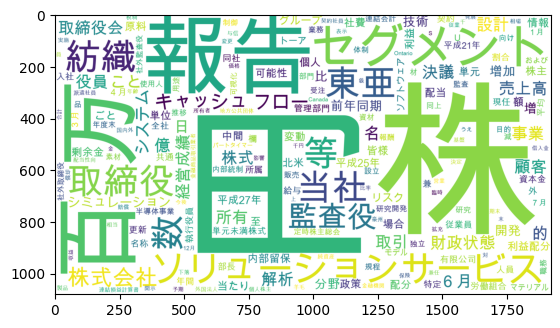

In [11]:
import glob
import collections
import math
from tqdm import tqdm

# ファイルを読み込む
files = glob.glob("/Users/tsuchitakouji/Documents/WorkShop/AI/20230421/2014/docs/S1004A*.txt", recursive=True)
print(files)

# 語の文書頻度の数を数えるためのハッシュ
doc_hash = collections.defaultdict(int)

# ファイルを読み込んで、単語の文書頻度を数を数える
for f in tqdm(files):
    word_hash = {}
    lines = [lines.strip() for lines in open(f, "r", encoding="utf-8")]
    for line in lines:
        if lines == "":
            continue
        words = extract_words(line)
        for w in words:
            word_hash[w] = 1
    for w in word_hash.keys():
        doc_hash[w] += 1

all_word_data = ""
# TFIDFを計算する
for f in tqdm(files):
    word_hash = collections.defaultdict(int)
    tfidf_hash = {}
    lines = [lines.strip() for lines in open(f, "r", encoding="utf-8")]
    for line in lines:
        if lines == "":
            continue
        words = extract_words(line)
        for w in words:
            word_hash[w] += 1
    for w, tf in word_hash.items():  
        ids = math.log2(float(len(files)) / float(doc_hash[w]) )
        tfidf_hash[w] = tf * ids

    keys = sorted(tfidf_hash.keys(), key=lambda k:tfidf_hash[k], reverse=True)

    print(" --- start output --- ")
    print(f)
    fp = open("tfidf_result_" + f.split("/")[-1], "w", encoding="utf-8")
    word_data = ""
    for i, w in enumerate(keys[:30]):
        print(w,tfidf_hash[w])
        fp.write(w + " " + str(word_hash[w]) + " " + str(doc_hash[w]) + " " + str(tfidf_hash[w]) )
        word_data = word_data + w + ","
        all_word_data = all_word_data + w + ","
    print(word_data)
    fp.close()
    print(" --- end   output --- ")

output_wordcloud(all_word_data,filename="tfidf_result_all.png")